In [16]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from mpl_toolkits import mplot3d
from helper_functions import *
from system_theta import system_theta

#generate jose BZ boundary path
def gen_delbz_jose(N, deltaK):
    pt1 = deltaK * np.array([0, 1])
    pt2 = deltaK * np.array([np.sqrt(3) / 2, -0.5])
    pt3 = deltaK * np.array([0, -2])
    pt4 = deltaK * np.array([-np.sqrt(3) / 2, -0.5])

    path1 = generate_path_special(N // 4, pt1, pt4, 0)
    path2 = generate_path_special(N // 4, pt2, pt3, 1)
    path3 = generate_path_special(N // 4, pt4, pt3, 1)
    path4 = generate_path_special(N // 4, pt1, pt2, 0)

    #for our purposes we compare paths 1 and 2 and 3 and 4

    out1 = np.zeros((N // 4, 2, 2))
    out2 = np.zeros((N // 4, 2, 2))

    out1[:, 0, :] = path1
    out1[:, 1, :] = path2
    out2[:, 0, :] = path3
    out2[:, 1, :] = path4

    return out1, out2

#for checking whether wf's are actually the same
def comp(gs1, gs2):
    out = np.zeros_like(gs1)
    for i in range(len(gs1)):
        np.abs(gs1[i]) - np.abs(gs2[i])
    return LA.norm(out)

def get_phase_diff(system, path1, path2, U):
    phase_diff = np.zeros(len(path1))
    disc_indices = []
    prev_phi1, prev_phi2 = 0, 0

    for i in range(len(path1)):
        kx = path1[i, 0]
        ky = path1[i, 1]
        gs1 = leveln(kx, ky, system.Qs, system.deltaK, system.t, system.theta, system.vf, 0, N=None, U=U)
        
        kx = path2[i, 0]
        ky = path2[i, 1]
        gs2 = leveln(kx, ky, system.Qs, system.deltaK, system.t, system.theta, system.vf, 0, N=None, U=U)

        midband = gs1.shape[0] // 2

        gs1 = gs1 * np.exp(-1j * np.angle(gs1[midband]))
        gs2 = gs2 * np.exp(-1j * np.angle(gs2[midband]))

        ph1 = np.dot(np.ones(gs1.shape[0]), gs1) / np.sqrt(gs1.shape[0])
        ph2 = np.dot(np.ones(gs2.shape[0]), gs2) / np.sqrt(gs1.shape[0])

        phase_diff[i] = (np.angle(ph1) - np.angle(ph2)) / (2 * np.pi)

        phi1_temp, phi2_temp = np.angle(ph1), np.angle(ph2)

        bound = 0.5 * np.pi

        if i > 0 and np.abs(phi1_temp - prev_phi1) > bound:
            disc_indices.append((i, (phi1_temp - prev_phi1)/np.pi/2))
        elif i > 0 and np.abs(phi2_temp - prev_phi2) > bound:
            disc_indices.append((i, -(phi2_temp - prev_phi2)/np.pi/2))

        prev_phi1, prev_phi2 = phi1_temp, phi2_temp

    disc_indices.append((len(path1), 0))
    print(disc_indices)

    return phase_diff, disc_indices

def integrate_phase_diff(N, theta, U):
    system = system_theta(theta)
    #first pair of sides and second pair of sides
    delbz_p1, delbz_p2 = gen_delbz_jose(N, system.deltaK)
    path1, path2 = delbz_p1[:, 0, :], delbz_p1[:, 1, :]
    phase_diffs1, disc_indices1 = get_phase_diff(system, path1, path2, U)

    path3, path4 = delbz_p2[:, 0, :], delbz_p2[:, 1, :]
    phase_diffs2, disc_indices2 = get_phase_diff(system, path3, path4, U)
    
    phase_diffs1 = remove_discontinuities(phase_diffs1, disc_indices1)
    phase_diffs2 = remove_discontinuities(phase_diffs2, disc_indices2)

    return phase_diffs1, phase_diffs2

def remove_discontinuities(phase_diffs, disc_indices):
    temp, _ = disc_indices[0]
    tot_disc = 0

    for d in disc_indices:
        index, disc = d
        if index !=temp:
            for i in range(temp, index):
                phase_diffs[i] -= tot_disc
            temp = index
        tot_disc += disc

    return phase_diffs

def save_plots_phase_diff(N, theta, U):

    sgn = 1

    folder = "phase_diff_plots_staggeredV"
    file_name = f'{np.degrees(theta)}, staggeredV={U},_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'

    if not os.path.exists(folder):
        os.makedirs(folder)

    rootpath = os.path.join(folder, file_name)
    phase_diffs1, phase_diffs2 = integrate_phase_diff(N, theta, U)
    x_axis = np.arange(len(phase_diffs1))

    plt.plot(x_axis, phase_diffs1)
    plt.title("Phase difference between paths 1 and 2")
    plt.xlabel("Index")
    plt.ylabel("Phase Difference")
    plt.savefig(rootpath + " dphi1.png")
    plt.clf()

    plt.plot(x_axis, phase_diffs2)
    plt.title("Phase difference between paths 3 and 4")
    plt.xlabel("Index")
    plt.ylabel("Phase Difference")
    plt.savefig(rootpath + " dphi2.png")
    plt.clf()

    x_axis = np.arange(len(phase_diffs1) + len(phase_diffs2))
    new_plot = np.zeros(2 * len(phase_diffs1))
    new_plot[:len(phase_diffs1)] = phase_diffs1 - phase_diffs1[0]
    new_plot[len(phase_diffs1):] = (phase_diffs2-phase_diffs2[0]) + new_plot[len(phase_diffs1)-1]

    plt.plot(x_axis, new_plot)
    plt.title("Total phase?")
    plt.xlabel("Index")
    plt.ylabel("Phase Difference")
    plt.savefig(rootpath + " total phase?.png")
    plt.clf()

    content = f'Differences: \n Phase difference 1 {new_plot[len(phase_diffs1)-1]} \n Phase difference final {new_plot[-1]} \n'
    with open(rootpath + ".txt", "w") as text_file:
        text_file.write(content)

#this checks equality of wavefunctions
def check_wfs(theta, U):
    system = system_theta(theta)
    N = 200
    delbz_p1, delbz_p2 = gen_delbz_jose(N * 4, system.deltaK)
    path1, path2 = delbz_p1[:, 0, :], delbz_p1[:, 1, :]
    path3, path4 = delbz_p2[:, 0, :], delbz_p2[:, 1, :]
    comps = np.ones(5)

    step = int(np.round(N / 4)) - 1

    for e in range(5):
        i = int(e * step)
        kx = path1[i, 0]
        ky = path1[i, 1]
        gs1 = leveln(kx, ky, system.Qs, system.deltaK, system.t, system.theta, system.vf, 0, N=None, U=U)
        
        kx = path3[i, 0]
        ky = path3[i, 1]
        gs2 = leveln(kx, ky, system.Qs, system.deltaK, system.t, system.theta, system.vf, 0, N=None, U=U)

        if np.array_equal(gs1, gs2):
            print('calamity')
            return
        comps[e] = comp(gs1, gs2)
    return comps

#this checks for where the minima are, to see if they move.
def check_wfs2(theta, U):
    system = system_theta(theta)
    N = 200
    delbz_p1, _ = gen_delbz_jose(N * 4, system.deltaK)
    path1, path2 = delbz_p1[:, 0, :], delbz_p1[:, 1, :]
    comps = np.ones(200)

    step = int(np.round(N / 4)) - 1

    vecs = []
    
    for i in range(200):
        kx = path1[i, 0]
        ky = path1[i, 1]
        gs1 = leveln(kx, ky, system.Qs, system.deltaK, system.t, system.theta, system.vf, 0, N=None, U=U)

        min_index = np.argmax(np.abs(gs1))
        max_index = np.argmin(np.abs(gs1))

        comps[i] = (gs1[min_index] - gs1[max_index]) / np.abs(gs1[min_index])
        if i % 40 == 0:
            vecs.append(gs1[:3])
    return vecs

save_plots_phase_diff(20000, np.radians(10), 0.08)

[(1672, 0.9756631329243645), (5000, 0)]
[(632, 0.9999511014739035), (1667, -0.9375337134131349), (3586, 0.9999549171845462), (3841, -0.9999730747553166), (5000, 0)]


<Figure size 640x480 with 0 Axes>

In [17]:
angles = [1, 3.9, 5, 6, 7, 8, 9]
for angle in angles:
    save_plots_phase_diff(20000, np.radians(angle), 0.08)

[(2764, 0.9998933037772589), (5000, 0)]
[(5000, 0)]
[(1734, 0.9977507115858693), (5000, 0)]
[(619, 0.9999191437028494), (1674, -0.9947864869761139), (5000, 0)]
[(1700, 0.9957891562944298), (5000, 0)]
[(623, 0.9999246807693317), (1670, -0.990354153055946), (5000, 0)]
[(1687, 0.9934060529442338), (5000, 0)]
[(626, 0.9999310324980876), (1668, -0.9841969179451163), (4866, -0.28988101880381223), (5000, 0)]
[(1680, 0.9901146133585375), (5000, 0)]
[(628, 0.9999370297006873), (1668, -0.9773579810390224), (4902, -0.25028684568932136), (5000, 0)]
[(1676, 0.9859876705556563), (5000, 0)]
[(630, 0.9999424278258647), (1668, -0.9695177944188965), (5000, 0)]
[(1674, 0.9833777681037958), (5000, 0)]
[(631, 0.9999470568289184), (1667, -0.9528651034020201), (4940, -0.315553431125654), (5000, 0)]


<Figure size 640x480 with 0 Axes>

### Checking that the wavefunctions are the same. This is actually kind of shocking. They are very precisely the same.

In [7]:
check_wfs(np.radians(3.9), 0.5)

array([0., 0., 0., 0., 0.])

In [8]:
z = 1+1j

print(z * np.exp(-1j * np.angle(z)))

(1.414213562373095+1.1102230246251565e-16j)


### checking the orientations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


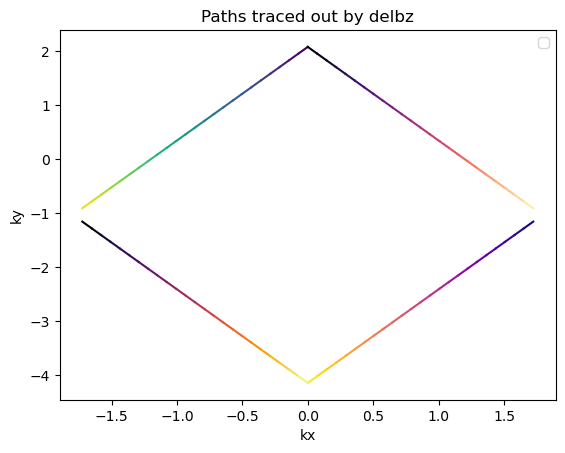

In [9]:
from system_theta import system_theta
from helper_functions import *
from matplotlib import pyplot as plt
import matplotlib.cm as cm


# BEGIN: Plot paths
N = 100  # Example value for N
theta = 0.5  # Example value for theta

system = system_theta(theta)
delbz_p1, delbz_p2 = gen_delbz_jose(N, system.deltaK)

path1, path2 = delbz_p1[:, 0, :], delbz_p1[:, 1, :]
path3, path4 = delbz_p2[:, 0, :], delbz_p2[:, 1, :]

# plt.plot(path1[:, 0], path1[:, 1], label='Path 1', color='blue')
# plt.plot(path2[:, 0], path2[:, 1], label='Path 2', color='green')
# plt.plot(path3[:, 0], path3[:, 1], label='Path 3', color='red')
# plt.plot(path4[:, 0], path4[:, 1], label='Path 4', color='purple')

# Generate colors based on the index
colors1 = cm.viridis(np.linspace(0, 1, len(path1)))
colors2 = cm.plasma(np.linspace(0, 1, len(path2)))
colors3 = cm.inferno(np.linspace(0, 1, len(path3)))
colors4 = cm.magma(np.linspace(0, 1, len(path4)))

# Plot paths with changing colors
for i in range(len(path1)):
    plt.plot(path1[i:i+2, 0], path1[i:i+2, 1], color=colors1[i])
    plt.plot(path2[i:i+2, 0], path2[i:i+2, 1], color=colors2[i])
    plt.plot(path3[i:i+2, 0], path3[i:i+2, 1], color=colors3[i])
    plt.plot(path4[i:i+2, 0], path4[i:i+2, 1], color=colors4[i])

plt.xlabel('kx')
plt.ylabel('ky')
plt.title('Paths traced out by delbz')
plt.legend()
plt.show()

### let's try making some plots